### Manual trading #1: Best conversion

In [131]:
import numpy as np

Define the conversion manual

## Method 1: Brute force

In [132]:
conversions = {
    'Snowball': [('Snowball',1), ('Pizza',1.45), ('Nuggets',0.52), ('Seashell',0.72)],
    'Pizza': [('Snowball', 0.7), ('Pizza', 1), ('Nuggets', 0.31), ('Seashell',0.48)],
    'Nuggets': [('Snowball', 1.95), ('Pizza', 3.1), ('Nuggets', 1), ('Seashell', 1.49)],
    'Seashell': [('Snowball', 1.34), ('Pizza', 1.98), ('Nuggets', 0.64), ('Seashell', 1)],
}

max_steps = 5
start_currency = 'Seashell'
start_amount = 5000

best_result = {'amount': 0, 'path': []}

def dfs(current_currency, amount, steps, path):
    if steps > max_steps:
        return

    if steps > 0 and current_currency == start_currency:
        if amount > best_result['amount']:
            best_result['amount'] = amount
            best_result['path'] = path[:]
        return

    for next_currency, rate in conversions[current_currency]:
        dfs(next_currency, amount * rate, steps + 1, path + [next_currency])

#Start DFS
dfs(start_currency, start_amount, 0, [start_currency])

print(f"Regturn: {best_result['amount']/start_amount:.6f}")
print(f"Path: {' -> '.join(best_result['path'])}")

Regturn: 1.088680
Path: Seashell -> Snowball -> Nuggets -> Pizza -> Snowball -> Seashell


## Method 2: Using Bellmand Ford's algorithm to find the optimal path

In [133]:
conversions = {
    'Snowball': [('Snowball',np.log(1/1)), ('Pizza',np.log(1/1.45)), ('Nuggets',np.log(1/0.52)), ('Seashell',np.log(1/0.72))],
    'Pizza': [('Snowball', np.log(1/0.7)), ('Pizza', np.log(1/1)), ('Nuggets', np.log(1/0.31)), ('Seashell', np.log(1/0.48))],
    'Nuggets': [('Snowball', np.log(1/1.95)), ('Pizza', np.log(1/3.1)), ('Nuggets', np.log(1/1)), ('Seashell', np.log(1/1.49))],    
    'Seashell': [('Snowball', np.log(1/1.34)), ('Pizza', np.log(1/1.98)), ('Nuggets', np.log(1/0.64)), ('Seashell', np.log(1/1))],
    }

Define the function that generates graphs

In [134]:
def generate_graph(n, conversions):
    graph = {}
    if n == 1 or n == 2:
        print('Not large enough!')
        return
    graph['Seashell1'] = [(key+'2', value) for key, value in conversions['Seashell']]
    for i in range (1,n-1):
        for item in conversions.keys():
            if i == (n-2):
                graph[item + str(i+1)] = [('Seashell'+str(i+2), conversions[item][3][1])]    
            else:
                graph[item + str(i+1)] = [(key+str(i+2), value) for key, value in conversions[item]]
    graph['Seashell' + str(i+2)] = []
    return graph
        





C:\Users\Maria\AppData\Local\Temp\ipykernel_23044\1711978379.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


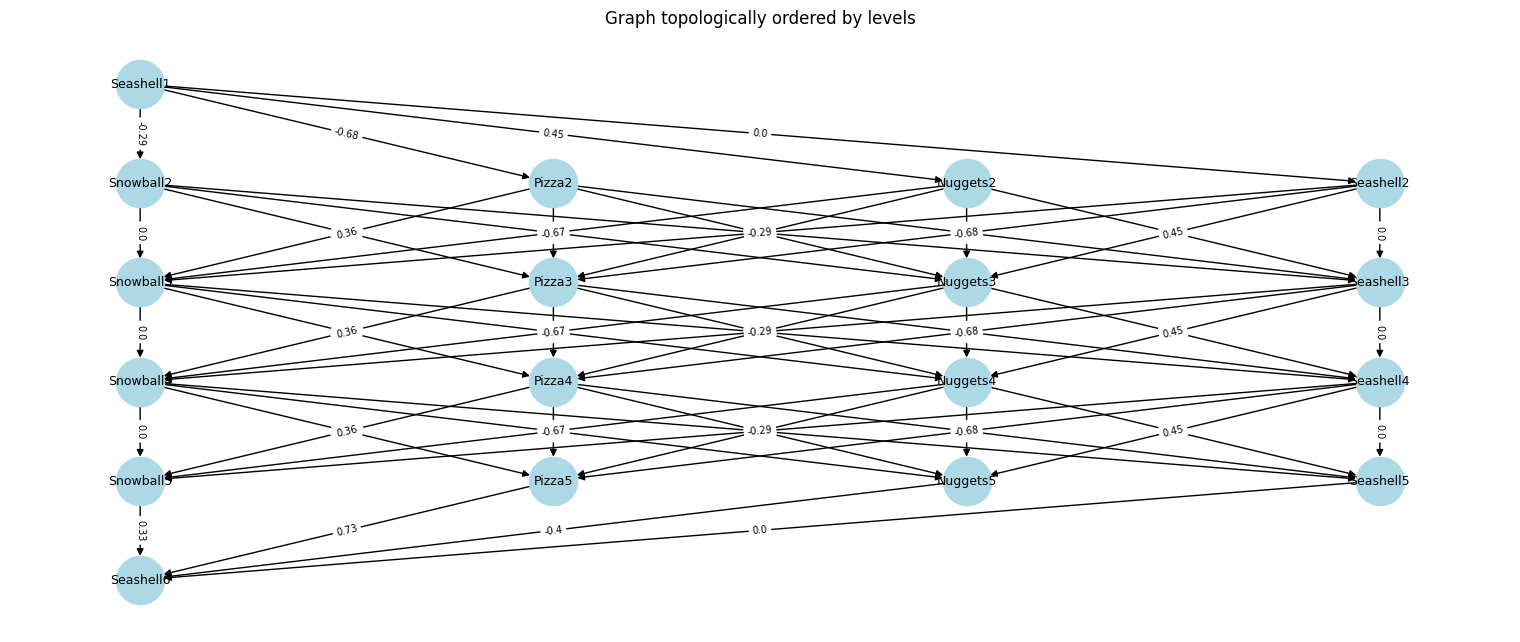

In [135]:
import networkx as nx
import matplotlib.pyplot as plt

def build_graph(data):
    G = nx.DiGraph()
    for node, neighbors in data.items():
        for neighbor, weight in neighbors:
            G.add_edge(node, neighbor, weight=round(weight, 2))
    return G

def topological_layout(G):
    order = list(nx.topological_sort(G))
    pos = {}
    layer_map = {}

    # Determine the level (depth) of each node
    for node in order:
        predecessors = list(G.predecessors(node))
        if not predecessors:
            layer = 0
        else:
            layer = max(layer_map[p] for p in predecessors) + 1
        layer_map[node] = layer

    # Group nodes by layers
    from collections import defaultdict
    layers = defaultdict(list)
    for node, layer in layer_map.items():
        layers[layer].append(node)

    # Assign positions
    pos = {}
    for y, nodes in layers.items():
        for x, node in enumerate(nodes):
            pos[node] = (x, -y)  # x: horizontal; -y: descending levels

    return pos

# --- Your graph ---
graph = generate_graph(6, conversions)

# --- Create graph and layout ---
G = build_graph(graph)
pos = topological_layout(G)

# --- Draw ---
plt.figure(figsize=(15, 6))
nx.draw(G, pos, with_labels=True, node_color="lightblue", node_size=1200, font_size=9, arrows=True)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=7)

plt.title("Graph topologically ordered by levels")
plt.tight_layout()
plt.show()

In [136]:
def bellman_ford(graph, source, destination):
    # Initialize distances and predecessors
    distances = {node: float('inf') for node in graph}
    distances[source] = 0
    predecessors = {node: None for node in graph}

    # Relax all edges |V| - 1 times
    for _ in range(len(graph) - 1):
        for current_node in graph:
            for neighbor, weight in graph[current_node]:
                if distances[current_node] + weight < distances[neighbor]:
                    distances[neighbor] = distances[current_node] + weight
                    predecessors[neighbor] = current_node

    # Check for negative cycles
    for current_node in graph:
        for neighbor, weight in graph[current_node]:
            if distances[current_node] + weight < distances[neighbor]:
                raise ValueError("The graph contains a negative cycle")

    # Reconstruct the path
    path = []
    node = destination
    while node is not None:
        path.insert(0, node)
        node = predecessors[node]

    if distances[destination] == float('inf'):
        return float('inf'), []  # No path

    return distances[destination], path


In [139]:
best_solutions = {}

for i in range(3, 7):
    distance, path = bellman_ford(generate_graph(i, conversions), 'Seashell1', 'Seashell' + str(i))
    distance = 1 / np.exp(distance)
    best_solutions[i] = [distance, path]

best = 0
best_n = None
for x, y in best_solutions.items():
    if y[0] >= best:
        best = y[0]
        best_n = x

print(path,best)

['Seashell1', 'Snowball2', 'Nuggets3', 'Pizza4', 'Snowball5', 'Seashell6'] 1.0886803200000001


We obtain the same solution using both 